In [10]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import random
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, FileLink

# Setting the random seed for reproducibility
random.seed(2)
%matplotlib inline

In [11]:
original_drowsy_dataset_dir         = './data/original_dataset/Drowsy'
original_nondrowsy_dataset_dir      = './data/original_dataset/NonDrowsy'
ff_train_dir                        = './data/ff_manual_annotate/train'
ff_test_dir                         = './data/ff_manual_annotate/test'
ff_train_drowsy_dir                 = './data/ff_manual_annotate/train/Drowsy'
ff_train_nondrowsy_dir              = './data/ff_manual_annotate/train/NonDrowsy'
ff_test_drowsy_dir                  = './data/ff_manual_annotate/test/Drowsy'
ff_test_nondrowsy_dir               = './data/ff_manual_annotate/test/NonDrowsy'
eye_train_dir                       = './data/eye_cropped/train'
eye_test_dir                        = './data/eye_cropped/test'
eye_train_drowsy_dir                = './data/eye_cropped/train/Drowsy'
eye_train_nondrowsy_dir             = './data/eye_cropped/train/NonDrowsy'
eye_test_drowsy_dir                 = './data/eye_cropped/test/Drowsy'
eye_test_nondrowsy_dir              = './data/eye_cropped/test/NonDrowsy'
ff_plot_dir                         = './plots/full_face'
eye_plot_dir                        = './plots/eye'
results_dir                         = './results'
model_dir                           = './models'
plot_dir                            = './plots'

`Dataset`

The Driver Drowsiness Dataset (DDD) (https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/) is an extracted and cropped faces of drivers from the videos of the Real-Life Drowsiness Dataset. The frames were extracted from videos as images using VLC software. After that, the Viola-Jones algorithm has been used to extract the region of interest from captured images. The dataset on Kaggle has following properties

The dataset has the following properties :
• RGB images
• 2 classes (Drowsy & Non Drowsy)
• Size of image : 227 x 227
• More than 41,790 images in total


In [12]:
def get_file_count(folder_path):
    """
    Get the count of files in a folder.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        int: The count of files in the folder.
    """
    # Get the list of files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    file_count = len(files)

    return file_count

In [13]:


# Get the file counts
drowsy_count = get_file_count(original_drowsy_dataset_dir)
non_drowsy_count = get_file_count(original_nondrowsy_dataset_dir)

# Create a dataframe
df = pd.DataFrame({'Category': ['Drowsy', 'Non Drowsy'], 'Count': [drowsy_count, non_drowsy_count]})

# Display the dataframe
display(df)


Category  Count
0      Drowsy  22348
1  Non Drowsy  19445

Drowsy folder contains around 22348 files and Non Drowsy folder contains around 19445 files. Upon further analysis it was found that there were multiple images of same person increasing the count in dataset. Also, the data set seemed to have incorrect labeling. Lot of images that seemed Non Drowsy were labeled as Drowsy. 

Hence, a concious decision was taken to manually label 10 images of each person that distinctly categorized image as drowsy and Non Drowsy.


In [14]:
# Get the file counts
train_drowsy_count          = get_file_count(ff_train_drowsy_dir)
train_non_drowsy_count      = get_file_count(ff_train_nondrowsy_dir)
test_drosy_count            = get_file_count(ff_test_drowsy_dir)
test_nondrowsy_count        = get_file_count(ff_test_nondrowsy_dir)

total_drowsy_count = train_drowsy_count + test_drosy_count
total_non_drowsy_count = train_non_drowsy_count + test_nondrowsy_count

# Create a dataframe
df = pd.DataFrame({'Category': ['Drowsy', 'Non Drowsy'], 'Count': [total_drowsy_count, total_non_drowsy_count]})

# Display the dataframe
display(df)

Category  Count
0      Drowsy    276
1  Non Drowsy    234

A comprehensive dataset comprising 510 images underwent manual annotation. These images are designated for training, validation, and testing purposes. They are to be divided into respective subsets for training, validation, and testing, adhering to a proportional allocation of 60%, 20%, and 20%. Given the nature of the labeling process, which involved approximately 10 images per individual, there exists a potential overlap wherein the test subset might include images of individuals previously encountered during the model's training phase. To address this and to assess the model's performance with previously unseen data, a distinct set of images, specifically those featuring individuals whose names commence with letters S through Z, has been segregated. This measure is intended to evaluate the model's generalization capabilities on novel data.

`Drowsy Annotated Images`

In [15]:
def plot_images(directory, title):
    """
    Plot images from a directory.

    Args:
        directory (str): The path to the directory containing the images.
        title (str): The title to be displayed above the images.
    """

    # Get the list of image files in the directory
    image_files = os.listdir(directory)

    # Create a figure with a grid of 1x4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    # Loop through the first 4 image files
    for i in range(4):
        # Get the image file path
        image_file = os.path.join(directory, image_files[i])
        
        # Open the image using PIL
        image = Image.open(image_file)
        
        # Display the image in the corresponding subplot
        axs[i].imshow(image)
        axs[i].axis('on')
        
        # Display the label above the image
        axs[i].set_title(title, fontsize=10, pad=2)
        
        # Add grid lines to the subplot
        axs[i].grid(True)

    # Show the figure
    plt.show()


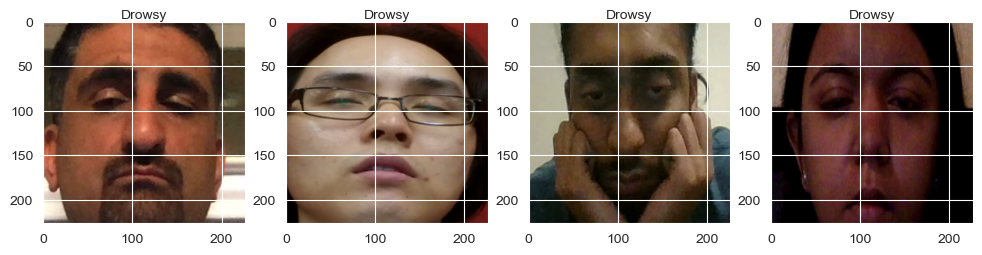

In [16]:
# Set the directory path
plot_images(directory = ff_train_drowsy_dir, title = 'Drowsy')

`Non Drowsy Annotated Images`

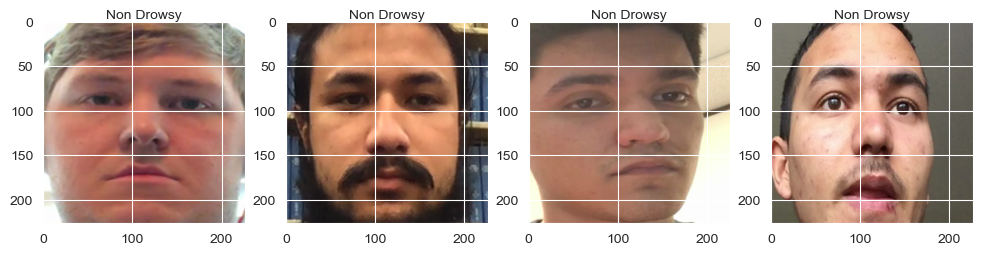

In [17]:
plot_images(directory = ff_train_nondrowsy_dir, title = 'Non Drowsy')

`Preprocessing`

The preprocessing of the image dataset will be executed through a two-stage process. Initially, the first stage will involve the random selection of 150 images each from directories labeled 'Drowsy' and 'NonDrowsy'. Selecting equal images would balance our dataset. In this phase, images from the 'Drowsy' directory will be annotated with a label of 1, while those from the 'NonDrowsy' directory will receive a label of 0, thus facilitating binary classification.

Subsequently, the second stage of preprocessing will focus on standardizing the dimensions of the images to a uniform size of 80x80 pixels. The data is split in training, validation and test set in this step. Additionally, this stage will incorporate various image augmentation techniques, including the adjustment of brightness and contrast, as well as the horizontal flipping of images. These augmented images will then be systematically incorporated into the training dataset, thereby enriching it and potentially enhancing the robustness of the model by exposing it to a more diverse range of data variations.

In [18]:
def data_preprocess_step1(train_dir, num_images=150):
    """
    Preprocess the data by randomly selecting a specified number of images from each subdirectory.

    Args:
        train_dir (str): The path to the directory containing the subdirectories of images.
        num_images (int, optional): The number of images to randomly select from each subdirectory. Defaults to 150.

    Returns:
        numpy.ndarray: The preprocessed images as a numpy array.
        numpy.ndarray: The corresponding labels as a numpy array.
    """

    # create empty lists to store the images and their labels
    images = []
    labels = []

    # loop through each subdirectory
    for subdir in os.listdir(train_dir):
        path = os.path.join(train_dir, subdir)
        print(path)
        if os.path.isdir(path):

            # get a list of all the image files in the subdirectory
            image_files = os.listdir(path)

            # randomly select num_images images from the list
            random.seed(12356)
            np.random.seed(12356)
            selected_images = random.sample(image_files, num_images)

            # loop through the selected images
            for image_file in selected_images:
                # load the image using load_img               
                img = load_img(os.path.join(path, image_file), target_size=(80, 80))

                # convert the image to an array using img_to_array
                img_array = img_to_array(img)

                # append the image and its label to the lists
                images.append(img_array)
                
                if subdir == "Drowsy":
                    labels.append(1)
                else:
                    labels.append(0)

    # convert the images and labels to numpy arrays
    images = np.stack(images)
    labels = np.array(labels).flatten()
    return images, labels

In [19]:
def preprocess_data_step2(images, y, split=(0.8,0.2), IMAGE_SIZE=(80,80), CONTRAST_FACTOR=3, DELTA=0.3, normalize=True):
    """
    Preprocess the data by creating train/validation sets and applying image transformations.

    Args:
        images (numpy.ndarray): The preprocessed images as a numpy array.
        y (numpy.ndarray): The corresponding labels as a numpy array.
        split (tuple, optional): The split ratio for train/validation sets. Defaults to (0.8, 0.2).
        IMAGE_SIZE (tuple, optional): The desired size of the images. Defaults to (80, 80).
        CONTRAST_FACTOR (int, optional): The contrast factor for adjusting contrast. Defaults to 3.
        DELTA (float, optional): The delta value for adjusting brightness. Defaults to 0.3.
        normalize (bool, optional): Whether to normalize the images. Defaults to True.

    Returns:
        numpy.ndarray: The preprocessed training images as a numpy array.
        numpy.ndarray: The corresponding training labels as a numpy array.
        numpy.ndarray: The preprocessed validation images as a numpy array.
        numpy.ndarray: The corresponding validation labels as a numpy array.
    """

 
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1235)
    np.random.seed(1235)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val = np.split(images, [splits[0]])
    y_train, y_val = np.split(y, [splits[0]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)

    
    # rescale image to [0,1], i.e., greyscale
    if normalize:
        X_train = X_train/255.0
        X_val = X_val/255.0

     
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    #X_train_augm = tfa.image.rotate(X_train_augm, np.random.uniform(-30, 30))
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val

In [20]:
def preprocess(train_dir, normalize=True):
    """
    Preprocess the data by performing two steps: 
    1. Randomly selecting 150 images from the train directory and converting them to arrays.
    2. Splitting the data into training, validation and applying image transformations.

    Args:
        train_dir (str): The path to the directory containing the subdirectories of images.
        normalize (bool, optional): Whether to normalize the images. Defaults to True.

    Returns:
        numpy.ndarray: The preprocessed training images as a numpy array.
        numpy.ndarray: The corresponding training labels as a numpy array.
        numpy.ndarray: The preprocessed validation images as a numpy array.
        numpy.ndarray: The corresponding validation labels as a numpy array.
    """

    # Preprocess step 1: Randomly select 150 images from 
    # the train directory and convert them to arrays
    images, y = data_preprocess_step1(train_dir, num_images=150)

    # Preprocess step 2: Split the data into training, validation
    X_train, y_train, X_val, y_val= preprocess_data_step2(
        images, y, split=(0.8,0.2), IMAGE_SIZE=(80,80), CONTRAST_FACTOR=3, DELTA=0.3, normalize=normalize)

    print('\n----------Preprocessing Summary----------')
    print(f"images shape {images.shape}")
    print(f"y shape {y.shape}")
    print(f"X_train shape {X_train.shape}")
    print(f"y_train shape {y_train.shape}")
    print(f"X_val shape {X_val.shape}")
    print(f"y_val shape {y_val.shape}")

    print

    return X_train, y_train, X_val, y_val


#### Model
TBD Describe model here

In [21]:
# This function builds a dynamic model for classifying drowsiness in drivers.
# It takes in various parameters to customize the architecture of the model.

def build_model_dynamic(num_conv=2, 
                        filters=[16, 16], 
                        kernel_size=[(5, 5), (5, 5)], 
                        strides=[(1, 1), (1, 1)], 
                        pool_size=[(2, 2), (2, 2)], 
                        pool_names=['pool_1', 'pool_2'], 
                        conv_dropout_rate=[0.3, 0.5], 
                        fc_dropout_rate=[0.5, 0, 0],
                        conv_batch_normalization=[True, True], 
                        fc_batch_normalization=[False, True, True],
                        activations=['relu', 'relu', 'relu', 'relu', 'relu'], 
                        num_dense=3, units=[128, 64, 32], 
                        conv_layer_names=['conv_1', 'conv_2'],
                        fc_layer_names=['fc_1', 'fc_2', 'fc_3', 'output']):
    """
    Build a dynamic model for classifying drowsiness in drivers.

    Args:
        num_conv (int, optional): The number of convolutional layers. Defaults to 2.
        filters (list, optional): The number of filters for each convolutional layer. Defaults to [16, 16].
        kernel_size (list, optional): The kernel size for each convolutional layer. Defaults to [(5, 5), (5, 5)].
        strides (list, optional): The stride for each convolutional layer. Defaults to [(1, 1), (1, 1)].
        pool_size (list, optional): The pool size for each max pooling layer. Defaults to [(2, 2), (2, 2)].
        pool_names (list, optional): The names for each max pooling layer. Defaults to ['pool_1', 'pool_2'].
        conv_dropout_rate (list, optional): The dropout rate for each convolutional layer. Defaults to [0.3, 0.5].
        fc_dropout_rate (list, optional): The dropout rate for each dense layer. Defaults to [0.5, 0, 0].
        conv_batch_normalization (list, optional): Whether to use batch normalization for each convolutional layer. Defaults to [True, True].
        fc_batch_normalization (list, optional): Whether to use batch normalization for each dense layer. Defaults to [False, True, True].
        activations (list, optional): The activation function for each layer. Defaults to ['relu', 'relu', 'relu', 'relu', 'relu'].
        num_dense (int, optional): The number of dense layers. Defaults to 3.
        units (list, optional): The number of units for each dense layer. Defaults to [128, 64, 32].
        conv_layer_names (list, optional): The names for each convolutional layer. Defaults to ['conv_1', 'conv_2'].
        fc_layer_names (list, optional): The names for each dense layer. Defaults to ['fc_1', 'fc_2', 'fc_3', 'output'].

    Returns:
        tf.keras.Sequential: The built model.
    """

    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()

    # Loop through the specified number of convolutional layers
    for _ in range(num_conv):
        # Add a convolutional layer with the specified parameters
        model.add(layers.Conv2D(filters[_], 
                                kernel_size=kernel_size[_], 
                                strides=strides[_],
                                padding='same',
                                data_format='channels_last',
                                name=conv_layer_names[_]))
        
        # Add batch normalization if specified
        if conv_batch_normalization[_]:
            model.add(layers.BatchNormalization())

        # Add the specified activation function
        model.add(layers.Activation(activations[_]))
        
        if conv_dropout_rate[_] != 0:
            # Add dropout layer with the specified dropout rate
            model.add(layers.Dropout(conv_dropout_rate[_]))

        # Add max pooling layer with the specified pool size
        model.add(layers.MaxPooling2D(pool_size=pool_size[_], name=pool_names[_]))



    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Loop through the specified number of dense layers
    for _ in range(num_dense):
        # Add a dense layer with the specified number of units
        model.add(layers.Dense(units[_], name=fc_layer_names[_]))

        # Add batch normalization if specified
        if fc_batch_normalization[_]:
            model.add(layers.BatchNormalization())
            
        # Add the specified activation function
        model.add(layers.Activation(activations[_]))

        if fc_dropout_rate[_] != 0:
            # Add dropout layer with the specified dropout rate
            model.add(layers.Dropout(fc_dropout_rate[_]))

    # Add the final dense layer with 1 unit for binary classification
    model.add(layers.Dense(1, activation=None, name=fc_layer_names[-1]))

    # Set the random seed and build the model with the specified input shape
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    return model
    
    

    

In [22]:
def build_optimizer(learning_rate=0.001, optimizer='adam'):
    """
    Build an optimizer for the model.

    Args:
        learning_rate (float, optional): The learning rate for the optimizer. Defaults to 0.001.
        optimizer (str, optional): The optimizer to use. Valid options are 'adam', 'sgd', and 'adagrad'. Defaults to 'adam'.

    Returns:
        tf.keras.optimizers.Optimizer: The built optimizer.
    
    Raises:
        ValueError: If an invalid optimizer is specified.
    """
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer specified.")
    return optimizer

In [23]:
def build_model_dyn(learning_rate=0.001, 
                    optimizer='adam', 
                    num_conv=2, 
                    filters=[16,16], 
                    kernel_size=[(5,5),(5,5)], 
                    strides=[(1,1),(1,1)], 
                    pool_size=[(2,2),(2,2)], 
                    pool_names=['pool_1', 'pool_2'], 
                    conv_dropout_rate=[0.3, 0.5], 
                    fc_dropout_rate=[0.5, 0, 0],
                    conv_batch_normalization=[True, True], 
                    fc_batch_normalization=[False, True, True],
                    activations=['relu', 'relu', 'relu', 'relu', 'relu'], 
                    num_dense=3, 
                    units=[128, 64, 32], 
                    conv_layer_names=['conv_1', 'conv_2'],
                    fc_layer_names=['fc_1', 'fc_2', 'fc_3', 'output']):  
    """
    Build a dynamic model for classifying drowsiness in drivers.

    Args:
        learning_rate (float, optional): The learning rate for the optimizer. Defaults to 0.001.
        optimizer (str, optional): The optimizer to use. Valid options are 'adam', 'sgd', and 'adagrad'. Defaults to 'adam'.
        num_conv (int, optional): The number of convolutional layers. Defaults to 2.
        filters (list, optional): The number of filters for each convolutional layer. Defaults to [16, 16].
        kernel_size (list, optional): The kernel size for each convolutional layer. Defaults to [(5, 5), (5, 5)].
        strides (list, optional): The stride for each convolutional layer. Defaults to [(1, 1), (1, 1)].
        pool_size (list, optional): The pool size for each max pooling layer. Defaults to [(2, 2), (2, 2)].
        pool_names (list, optional): The names for each max pooling layer. Defaults to ['pool_1', 'pool_2'].
        conv_dropout_rate (list, optional): The dropout rate for each convolutional layer. Defaults to [0.3, 0.5].
        fc_dropout_rate (list, optional): The dropout rate for each dense layer. Defaults to [0.5, 0, 0].
        conv_batch_normalization (list, optional): Whether to use batch normalization for each convolutional layer. Defaults to [True, True].
        fc_batch_normalization (list, optional): Whether to use batch normalization for each dense layer. Defaults to [False, True, True].
        activations (list, optional): The activation function for each layer. Defaults to ['relu', 'relu', 'relu', 'relu', 'relu'].
        num_dense (int, optional): The number of dense layers. Defaults to 3.
        units (list, optional): The number of units for each dense layer. Defaults to [128, 64, 32].
        conv_layer_names (list, optional): The names for each convolutional layer. Defaults to ['conv_1', 'conv_2'].
        fc_layer_names (list, optional): The names for each dense layer. Defaults to ['fc_1', 'fc_2', 'fc_3', 'output'].

    Returns:
        tf.keras.Sequential: The built model.
    """
    
    # Build the model architecture
    model = build_model_dynamic(
                                num_conv=num_conv,
                                filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                pool_size=pool_size,
                                pool_names=pool_names,
                                conv_dropout_rate=conv_dropout_rate,
                                fc_dropout_rate=fc_dropout_rate,
                                conv_batch_normalization=conv_batch_normalization,
                                fc_batch_normalization=fc_batch_normalization,
                                activations=activations,
                                num_dense=num_dense,
                                units=units,
                                conv_layer_names=conv_layer_names,
                                fc_layer_names=fc_layer_names)
    
    # Print the model summary
    model.summary()
    
    # Build the optimizer
    optimizer = build_optimizer(learning_rate, optimizer)
    
    # Compile the model with the optimizer, loss function, and metrics
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                metrics=['accuracy'])
    
    return model



`Baseline Accuracy`

In [24]:
def test_baseline_accuracy(model, test_dir, IMAGE_SIZE=(80,80), normalize=True):
    """
    Test the baseline accuracy of a model.

    Args:
        model (tf.keras.Sequential): The model to test.
        test_dir (str): The directory containing the test images.
        IMAGE_SIZE (tuple, optional): The size to resize the images to. Defaults to (80, 80).
        normalize (bool, optional): Whether to normalize the images. Defaults to True.
    """
    
    # Set random seeds for reproducibility
    tf.random.set_seed(1235)
    np.random.seed(1235)

    # Preprocess the test data
    image_test, label_test = data_preprocess_step1(test_dir, num_images=50)

    # Shuffle the test data
    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]
    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]

    # Resize the test images
    image_test = tf.image.resize(image_test, size=IMAGE_SIZE)

    # Normalize the test images if specified
    if normalize:
        image_test = image_test/255.0

    # Evaluate the model on the test data
    test_results = model.evaluate(image_test, label_test)

    # Print the test results
    print('\n----------Baseline Model Test Results----------')
    print('\nBaseline Test Acc. {:.2f}%'.format(test_results[1]*100))
    print('-----------------------------------------------')



In [25]:
def fit_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    """
    Fit the model to the training data and evaluate it on the validation data.

    Args:
        model (tf.keras.Sequential): The model to fit.
        X_train (numpy.ndarray): The training data.
        y_train (numpy.ndarray): The training labels.
        X_val (numpy.ndarray): The validation data.
        y_val (numpy.ndarray): The validation labels.
        epochs (int, optional): The number of epochs to train the model. Defaults to 20.
        batch_size (int, optional): The batch size for training. Defaults to 32.

    Returns:
        tf.keras.callbacks.History: The training history.
    """
    
    # Set random seeds for reproducibility
    tf.random.set_seed(6666)
    np.random.seed(6666)

    # Fit the model to the training data and evaluate it on the validation data
    history = model.fit(X_train, y_train,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(X_val, y_val)
    )
    
    return history


In [26]:
def plot_history(history, history_plot_file):
    """
    Plot the training history of a model.

    Args:
        history (tf.keras.callbacks.History): The training history.
        history_plot_file (str): The file path to save the plot.
    """
    
    # Extract the training history
    hist = history.history
    
    # Create an array of x values for plotting
    x_arr = np.arange(len(hist['loss'])) + 1

    # Create a figure with two subplots
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    
    # Plot the training loss
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    
    # Plot the validation loss
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    
    # Add legend and labels to the first subplot
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    # Create the second subplot
    ax = fig.add_subplot(1, 2, 2)
    
    # Plot the training accuracy
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    
    # Plot the validation accuracy
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    
    # Add legend and labels to the second subplot
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    
    # Show the plot
    plt.show()

    # Save the plot to a file if specified
    if history_plot_file != None:     
        fig.savefig(history_plot_file)
    


In [27]:
# Evaluate the model on the test data.
def evaluate_model(model, test_dir, normalize=True):
    """
    Evaluate the model on the test data.

    Args:
        model (tf.keras.Sequential): The model to evaluate.
        test_dir (str): The directory containing the test images.
        normalize (bool, optional): Whether to normalize the images. Defaults to True.

    Returns:
        float: The test accuracy.
    """
    
    tf.random.set_seed(1235)
    np.random.seed(1235)

    IMAGE_SIZE = (80, 80)

    # Preprocess the test data
    image_test, label_test = data_preprocess_step1(test_dir + '/', num_images=50)

    # Shuffle the test data
    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]

    # Resize the test images
    image_test = tf.image.resize(image_test, size=IMAGE_SIZE)

    # Normalize the test images if specified
    if normalize:
        image_test = image_test / 255.0

    # Evaluate the model on the test data
    test_results = model.evaluate(image_test, label_test)
    
    # Print the test accuracy results
    print('\n----------Model Test Accuracy Results----------')
    print('\nTest Acc. {:.2f}%'.format(test_results[1] * 100))
    print('-----------------------------------------------')

    return test_results[1] * 100


In [28]:
def preprocess_build_train_test(train_dir, 
                                test_dir, 
                                normalize=True, 
                                learning_rate=0.001, 
                                optimizer='adam',
                                epochs=20,
                                num_conv = 2, 
                                filters = [16,16], 
                                kernel_size = [(5,5),(5,5)], 
                                strides = [(1,1),(1,1)], 
                                pool_size = [(2,2),(2,2)], 
                                pool_names = ['pool_1', 'pool_2'], 
                                conv_dropout_rate= [0.3, 0.5], 
                                fc_dropout_rate = [0.5, 0, 0],
                                conv_batch_normalization = [True, True], 
                                fc_batch_normalization = [False, True, True],
                                activations = ['relu', 'relu', 'relu', 'relu', 'relu'], 
                                num_dense = 3, 
                                units = [128, 64, 32], 
                                conv_layer_names = ['conv_1', 'conv_2'],
                                fc_layer_names =['fc_1', 'fc_2', 'fc_3', 'output'],
                                history_plot_file = './plots/history.png',
                                batch_size=32):
    """
    Preprocess, build, train, and test a model for classifying drowsiness in drivers.

    Args:
        train_dir (str): The directory containing the training images.
        test_dir (str): The directory containing the test images.
        normalize (bool, optional): Whether to normalize the images. Defaults to True.
        learning_rate (float, optional): The learning rate for the optimizer. Defaults to 0.001.
        optimizer (str, optional): The optimizer to use. Valid options are 'adam', 'sgd', and 'adagrad'. Defaults to 'adam'.
        epochs (int, optional): The number of epochs to train the model. Defaults to 20.
        num_conv (int, optional): The number of convolutional layers. Defaults to 2.
        filters (list, optional): The number of filters for each convolutional layer. Defaults to [16, 16].
        kernel_size (list, optional): The kernel size for each convolutional layer. Defaults to [(5, 5), (5, 5)].
        strides (list, optional): The stride for each convolutional layer. Defaults to [(1, 1), (1, 1)].
        pool_size (list, optional): The pool size for each max pooling layer. Defaults to [(2, 2), (2, 2)].
        pool_names (list, optional): The names for each max pooling layer. Defaults to ['pool_1', 'pool_2'].
        conv_dropout_rate (list, optional): The dropout rate for each convolutional layer. Defaults to [0.3, 0.5].
        fc_dropout_rate (list, optional): The dropout rate for each dense layer. Defaults to [0.5, 0, 0].
        conv_batch_normalization (list, optional): Whether to use batch normalization for each convolutional layer. Defaults to [True, True].
        fc_batch_normalization (list, optional): Whether to use batch normalization for each dense layer. Defaults to [False, True, True].
        activations (list, optional): The activation function for each layer. Defaults to ['relu', 'relu', 'relu', 'relu', 'relu'].
        num_dense (int, optional): The number of dense layers. Defaults to 3.
        units (list, optional): The number of units for each dense layer. Defaults to [128, 64, 32].
        conv_layer_names (list, optional): The names for each convolutional layer. Defaults to ['conv_1', 'conv_2'].
        fc_layer_names (list, optional): The names for each dense layer. Defaults to ['fc_1', 'fc_2', 'fc_3', 'output'].
        history_plot_file (str, optional): The file path to save the history plot. Defaults to './plots/history.png'.
        batch_size (int, optional): The batch size for training. Defaults to 32.

    Returns:
        tf.keras.Sequential: The trained model.
        float: The test accuracy.
    """

    # Clear previous session and set random seeds for reproducibility
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Preprocess the training and validation data
    X_train, y_train, X_val, y_val = preprocess(train_dir, normalize=normalize)

    # Build the model
    model = build_model_dyn(learning_rate=learning_rate, 
                            optimizer=optimizer, 
                            num_conv=num_conv,
                            filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            pool_size=pool_size,
                            pool_names=pool_names,
                            conv_dropout_rate=conv_dropout_rate,
                            fc_dropout_rate=fc_dropout_rate,
                            conv_batch_normalization=conv_batch_normalization,
                            fc_batch_normalization=fc_batch_normalization,
                            activations=activations,
                            num_dense=num_dense,
                            units=units,
                            conv_layer_names=conv_layer_names,
                            fc_layer_names=fc_layer_names
                            )
    
    # Test the baseline accuracy of the model
    test_baseline_accuracy(model, test_dir, normalize=normalize)
    
    # Fit the model to the training data
    history = fit_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    
    # Plot the training history
    plot_history(history, history_plot_file=history_plot_file)
    
    # Evaluate the model on the test data
    test_acc = evaluate_model(model, test_dir, normalize=normalize)
    
    # Return the trained model and test accuracy
    return model, test_acc



In [29]:
def get_model_size(model):
    """
    Get the size of a model in megabytes.

    Args:
        model (tf.keras.Sequential): The model to get the size of.

    Returns:
        float: The size of the model in megabytes.
    """
    
    total_model_size = 0

    for layer in model.layers:
        for weight in layer.weights:
            param_size = weight.shape.num_elements() * weight.dtype.size
            total_model_size += param_size

    total_model_size_kb = total_model_size / 1024
    total_model_size_mb = total_model_size_kb / 1024

    print(f"Model size: {total_model_size_kb:.2f} KB or {total_model_size_mb:.2f} MB")

    return total_model_size_mb


In [30]:
from itertools import product

# Here we define the hyperparameters. We would be use permutations to 
# find the best hyperparameters for our model.


learning_rate               =   [0.001]
 
optimizer                   =   ['adam']
                                 
                        
filters                     =   [[16,16],
                                [16,8],
                                [8,16], 
                                [8,8]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)]] 
                                 
 
strides                     =   [[(1,1),(1,1)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [64, 64, 32]]

epochs                      =   [30, 40]

batch_size                  =   [16, 32, 64]

In [31]:
from itertools import product
# FF Good Configuration

learning_rate               =   [0.001]
 
optimizer                   =   ['adam']
                                 
                        
filters                     =   [[16,8]]

kernel_size                 =   [[(5,5),(5,5)]] 
                                 
 
strides                     =   [[(1,1),(1,1)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[64, 64, 32]]

epochs                      =   [40]

batch_size                  =   [16]

In [32]:
def build_permutations(lists):
    """
    Generate permutations of one element from each list.

    Args:
        lists (list): A list of lists containing elements for permutations.

    Returns:
        list: A list of all permutations.
    """

    # Generate permutations of one element from each list
    all_permutations = list(product(*lists))

    # Print the permutations
    for idx, permutation in enumerate(all_permutations, start=1):
        print(f"Permutation {idx}: {permutation}")

    return all_permutations

In [33]:
# Create a dictionary to store the data
data = {
    'Learning Rate': [],        # List to store learning rate values
    'Filters': [],              # List to store filter values
    'Kernel Size': [],          # List to store kernel size values
    'Strides': [],              # List to store stride values
    'optimizer': [],            # List to store optimizer values
    'Conv Dropout Rate': [],    # List to store convolutional dropout rate values
    'FC Dropout Rate': [],      # List to store fully connected dropout rate values
    'Units': [],                # List to store units values
    'Pool Size': [],            # List to store pool size values
    'Epochs': [],               # List to store epochs values
    'Batch Size': [],           # List to store batch size values
    'Test Accuracy': [],        # List to store test accuracy values
    'Model Size': [],           # List to store model size values
    'History Plot': []          # List to store history plot values
}


In [34]:
def create_directory(dir_path):
    """
    Create a directory if it doesn't exist.

    Args:
        dir_path (str): The path of the directory to create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def clear_dir(directory):
    """
    Clear the contents of a directory.

    Args:
        directory (str): The path of the directory to clear.
    """
    if os.path.exists(directory):
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

In [35]:
def predict_drowsy(model, dir_path, normalize=True, num_images=50):
    """
    Predict drowsiness using a trained model.

    Args:
        model: The trained model for drowsiness classification.
        dir_path: The directory path of the test images.
        normalize: A boolean indicating whether to normalize the test images. Default is True.
        num_images: The number of test images to use. Default is 50.

    Returns:
        image_test: The preprocessed test images.
        label_test: The labels of the test images.
    """

    # Preprocess the test images
    image_test, label_test = data_preprocess_step1(dir_path, num_images=num_images)
    np.random.seed(1235)
    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]
    image_test = tf.image.resize(image_test, size=(80,80))
    if normalize:
        image_test = image_test/255.0

    # Make predictions using the trained model
    pred_logits = model.predict(image_test)
    probas = tf.sigmoid(pred_logits)
    probas = probas.numpy().flatten()*100

    # Create a figure to display the test images and their predictions
    fig = plt.figure(figsize=(10, 50))

    # Iterate over each test example
    for j, example in enumerate(image_test):
        ax = fig.add_subplot(int(len(label_test)/4),4, j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(array_to_img(example))
        
        # Determine the ground truth label and the predicted probability of being drowsy
        if label_test[j]==0:
            label='Non Drowsy'
        else:
            label='Drowsy'
        
        # Display the ground truth label and the predicted probability
        ax.text(
            0.5, -0.15, 
            'GT: {:s}\nPr(Drowsy)={:.0f}%'.format(label, probas[j]), 
            size=10, 
            color='black',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

    return image_test, label_test

In [36]:
def plot_filter_activations(model, layer_name, input_image):
    """
    Plot the filter activations of a specified layer for an input image.

    Args:
        model (tf.keras.Model): The trained model.
        layer_name (str): The name of the layer to visualize.
        input_image (numpy.ndarray): The input image to generate activations.

    Returns:
        None
    """
    # Get the activations of the specified layer
    activations = model.get_layer(layer_name).output
    
    # Create a new model that outputs the activations of the specified layer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=activations)
    
    # Get the activations for the input image
    activations = activation_model.predict(input_image)
    
    # Get the number of filters in the layer
    num_filters = activations.shape[-1]
    
    # Calculate the number of rows and columns for the subplots
    num_rows = (num_filters + 3) // 4
    num_cols = min(num_filters, 4)
    
    # Create a grid to display the filter activations
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4*num_rows))
    
    # Iterate over each filter
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # Get the activation map for the current filter
            activation_map = activations[0, :, :, i]
            # Plot the activation map
            im = ax.imshow(activation_map, cmap='viridis')
            ax.axis('off')

            # Add a vertical color bar next to the image
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Remove empty subplots
    for ax in axes.flat[i+1:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()

In [37]:
def run_model_permutations(train_dir, test_dir, plot_dir, output_file_xls, output_file_csv):
    """
    Run model permutations and store the results in a dataframe and output files.

    Args:
        train_dir (str): The directory path of the training images.
        test_dir (str): The directory path of the test images.
        plot_dir (str): The directory path to store the plot files.
        output_file_xls (str): The path of the output Excel file.
        output_file_csv (str): The path of the output CSV file.

    Returns:
        list: A list of trained models.
        list: A list of test accuracies.
    """

    clear_dir(plot_dir)
    create_directory(plot_dir)

    model_list = []
    acc_list = []

    # Clear the data dictionary
    data['Learning Rate'].clear()
    data['Filters'].clear()
    data['Kernel Size'].clear()
    data['Strides'].clear()
    data['optimizer'].clear()
    data['Conv Dropout Rate'].clear()
    data['FC Dropout Rate'].clear()
    data['Units'].clear()
    data['Pool Size'].clear()
    data['Epochs'].clear()
    data['Batch Size'].clear()
    data['Test Accuracy'].clear()
    data['Model Size'].clear()
    data['History Plot'].clear()

    df = None

    lists = [learning_rate, optimizer, filters, kernel_size, strides, pool_size, 
                conv_dropout_rate, fc_dropout_rate, conv_batch_normalization, 
                fc_batch_normalization, activations, units, epochs, batch_size]

    all_permutations = build_permutations(lists)

    for idx, permutation in enumerate(all_permutations, start=1):

        clear_output(wait=True)

        print(f"Permutation {idx}/{len(all_permutations)}")

        # Preprocess, build, train, and test the model with the current permutation
        model, accuracy = preprocess_build_train_test(train_dir, 
                                                      test_dir, 
                                                      normalize=True, 
                                                      learning_rate=permutation[0], 
                                                      optimizer=permutation[1],
                                                      epochs=permutation[12],
                                                      batch_size=permutation[13],
                                                      num_conv=2, 
                                                      filters=permutation[2], 
                                                      kernel_size=permutation[3], 
                                                      strides=permutation[4], 
                                                      pool_size=permutation[5], 
                                                      pool_names=['pool_1', 'pool_2'], 
                                                      conv_dropout_rate=permutation[6], 
                                                      fc_dropout_rate=permutation[7],
                                                      conv_batch_normalization=permutation[8], 
                                                      fc_batch_normalization=permutation[9],
                                                      activations=permutation[10], 
                                                      num_dense=3, 
                                                      units=permutation[11], 
                                                      conv_layer_names=['conv_1', 'conv_2'],
                                                      fc_layer_names=['fc_1', 'fc_2', 'fc_3', 'output'],
                                                      history_plot_file=f'{plot_dir}/history_{idx}.png')

        model_list.append(model)
        acc_list.append(accuracy)


        # Append the permutation results to the data dictionary
        data['Learning Rate'].append(permutation[0])
        data['Filters'].append(permutation[2])
        data['Kernel Size'].append(permutation[3])
        data['Strides'].append(permutation[4])
        data['optimizer'].append(permutation[1])
        data['Conv Dropout Rate'].append(permutation[6])
        data['FC Dropout Rate'].append(permutation[7])
        data['Units'].append(permutation[11])
        data['Pool Size'].append(permutation[5])
        data['Epochs'].append(permutation[12])
        data['Batch Size'].append(permutation[13])
        data['Test Accuracy'].append(accuracy)
        data['Model Size'].append(get_model_size(model))
        data['History Plot'].append(f'{plot_dir}/history_{idx}.png')  

        df = pd.DataFrame(data) 
        # Add data to CSV and Excel files every 5 permutations
        if idx % 5 == 0:
            if os.path.exists(output_file_xls):
                os.remove(output_file_xls)

            df.to_excel(output_file_xls, index=False)
            df.to_csv(output_file_csv, index=False)



    if os.path.exists(output_file_xls):
        os.remove(output_file_xls)

    if os.path.exists(output_file_csv):
        os.remove(output_file_csv)

    if (df is None):
        df = pd.DataFrame(data)

    # Save the data to CSV and Excel files    
    df.to_excel(output_file_xls, index=False)
    df.to_csv(output_file_csv, index=False)

    df_sorted = df.sort_values(by='Test Accuracy', ascending=False)
    display(df_sorted)

    return model_list, acc_list




`Train and Evaluate (Full Face)`

Model would be trained using various permutations of hyperparameters defined and evaluated against test data

Permutation 1/1
./data/ff_manual_annotate/train/NonDrowsy
./data/ff_manual_annotate/train/Drowsy


2023-12-04 22:45:09.168864: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-04 22:45:09.168889: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-04 22:45:09.168894: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-04 22:45:09.169573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 22:45:09.170075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



----------Preprocessing Summary----------
images shape (300, 80, 80, 3)
y shape (300,)
X_train shape (480, 80, 80, 3)
y_train shape (480,)
X_val shape (60, 80, 80, 3)
y_val shape (60,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 80, 80, 16)        1216      
                                                                 
 batch_normalization (Batch  (None, 80, 80, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 80, 80, 16)        0         
                                                                 
 dropout (Dropout)           (None, 80, 80, 16)        0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 40, 40, 16)        0         
  

./data/ff_manual_annotate/test/NonDrowsy
./data/ff_manual_annotate/test/Drowsy


2023-12-04 22:45:10.117020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 42ms/step - loss: 0.6909 - accuracy: 0.5000

----------Baseline Model Test Results----------

Baseline Test Acc. 50.00%
-----------------------------------------------
Epoch 1/40


2023-12-04 22:45:11.408750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.5250

2023-12-04 22:45:13.046277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 3s 33ms/step - loss: 0.6992 - accuracy: 0.5250 - val_loss: 0.6914 - val_accuracy: 0.4667
Epoch 2/40
30/30 [==============================] - 1s 24ms/step - loss: 0.6739 - accuracy: 0.5458 - val_loss: 0.6882 - val_accuracy: 0.4667
Epoch 3/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6076 - accuracy: 0.6271 - val_loss: 0.6835 - val_accuracy: 0.4667
Epoch 4/40
30/30 [==============================] - 1s 22ms/step - loss: 0.5674 - accuracy: 0.6771 - val_loss: 0.7170 - val_accuracy: 0.4667
Epoch 5/40
30/30 [==============================] - 1s 23ms/step - loss: 0.4695 - accuracy: 0.7688 - val_loss: 0.6992 - val_accuracy: 0.4667
Epoch 6/40
30/30 [==============================] - 1s 23ms/step - loss: 0.3757 - accuracy: 0.8500 - val_loss: 0.6475 - val_accuracy: 0.4667
Epoch 7/40
30/30 [==============================] - 1s 23ms/step - loss: 0.2918 - accuracy: 0.8958 - val_loss: 0.5989 - val_accuracy: 0.4667
Epoch 8/40
30/30 [======

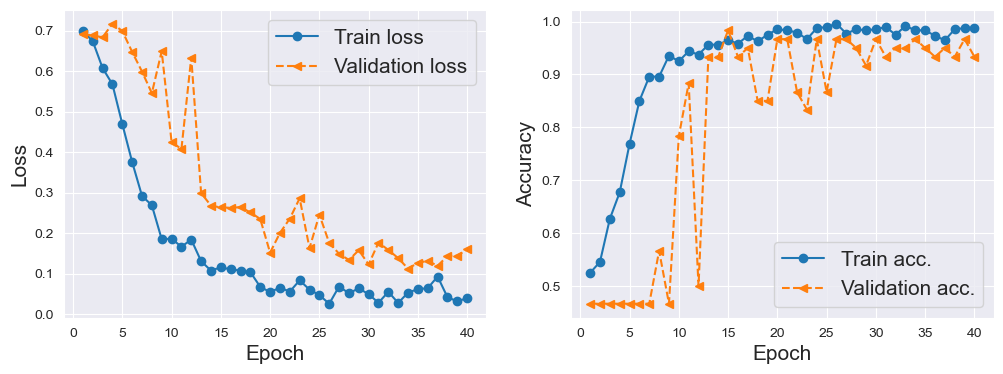

./data/ff_manual_annotate/test/NonDrowsy
./data/ff_manual_annotate/test/Drowsy
1/4 [======>.......................] - ETA: 0s - loss: 0.3393 - accuracy: 0.8750

2023-12-04 22:45:39.510620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 34ms/step - loss: 0.3467 - accuracy: 0.9000

----------Model Test Accuracy Results----------

Test Acc. 90.00%
-----------------------------------------------
Model size: 843.91 KB or 0.82 MB


Learning Rate  Filters       Kernel Size           Strides optimizer  \
0          0.001  [16, 8]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   

  Conv Dropout Rate FC Dropout Rate         Units         Pool Size  Epochs  \
0        [0.3, 0.5]     [0.5, 0, 0]  [64, 64, 32]  [(2, 2), (2, 2)]      40   

   Batch Size  Test Accuracy  Model Size                     History Plot  
0          16      89.999998    0.824131  ./plots/full_face/history_1.png

Best ff accuracy at index: 0 89.99999761581421%


In [38]:
import numpy as np

output_file_xls = results_dir + '/output_ff.xlsx'
output_file_csv = results_dir + '/output_ff.csv'

model_ff_list, model_ff_acc_list = run_model_permutations(ff_train_dir,
                                                            ff_test_dir,
                                                            ff_plot_dir,
                                                            output_file_xls,
                                                            output_file_csv)


ff_highest_accuracy_index = np.argmax(model_ff_acc_list)

print(f"Best ff accuracy at index: {ff_highest_accuracy_index} {model_ff_acc_list[ff_highest_accuracy_index]}%")

`Save Model`

Save the model with highest test accuracy for future use.

In [41]:
from keras.utils import plot_model

# Save the highest accuracy model from the model_ff_list
model_ff = model_ff_list[ff_highest_accuracy_index]
model_ff.save(model_dir + '/model_ff.keras')
model_ff.save(model_dir + '/model_ff.h5')

# save model_ff summary to file




You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


/Users/mayank/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


`Feature Reduction (Focus Eye)`

Maximum accuracy achieved with our approach was around 90 percent. To increase the accuracy and generalization we shifted our focus to specifically analyzing the eye region, rather than the entire face, for drowsiness detection. To facilitate this approach, we employed external libraries, namely 'face_recognition' and 'dlib', to precisely extract the eye regions from our annotated image dataset. These cropped eye images were then utilized for the training, validation, and testing phases of our model.

`Eye Drowsy/NonDrowsy Count`

We cropped eye from our annotated training dataset. We considered one eye per subject. 

In [ ]:

eye_train_drowsy        = get_file_count(eye_train_drowsy_dir)
eye_train_nondrowsy     = get_file_count(eye_train_nondrowsy_dir)
eye_test_drowsy         = get_file_count(eye_test_drowsy_dir)
eye_test_nondrowsy      = get_file_count(eye_test_nondrowsy_dir)

eye_drowsy_count        = eye_test_drowsy + eye_train_drowsy 
eye_nondrowsy_count     = eye_test_nondrowsy + eye_train_nondrowsy


# Create a dataframe
df = pd.DataFrame({'Category': ['Drowsy', 'Non Drowsy'], 'Count': [eye_drowsy_count, eye_nondrowsy_count]})

# Display the dataframe
display(df)


`Drowsy Eye Plots`

In [ ]:
plot_images(directory = eye_train_drowsy_dir, title = 'Drowsy')

`Non Drowsy Eye Plots`

In [ ]:
plot_images(directory = eye_train_nondrowsy_dir, title = 'Non Drowsy')

`Train and Evaluate (Eye)`

In [ ]:
import numpy as np

output_file_xls = results_dir + '/output_eye.xlsx'
output_file_csv = results_dir + '/output_eye.csv'

model_eye_list, model_eye_acc_list = run_model_permutations(eye_train_dir,
                                                            eye_test_dir,
                                                            eye_plot_dir,
                                                            output_file_xls,
                                                            output_file_csv)


eye_highest_accuracy_index = np.argmax(model_eye_acc_list)

print(f"Best eye accuracy at index: {eye_highest_accuracy_index} {model_eye_acc_list[eye_highest_accuracy_index]}%")

`Save Model With Highest Accuracy`

In [ ]:
# Save the highest accuracy model from the model_eye_list
model_eye = model_eye_list[eye_highest_accuracy_index]
model_eye.save(model_dir + '/model_eye.keras')
model_eye.save(model_dir + '/model_eye.h5')

#### Results

`Plot Predictions/Plot Activations (Full Face)`

./data/ff_manual_annotate/test/NonDrowsy
./data/ff_manual_annotate/test/Drowsy
4/4 [==============================] - 0s 25ms/step


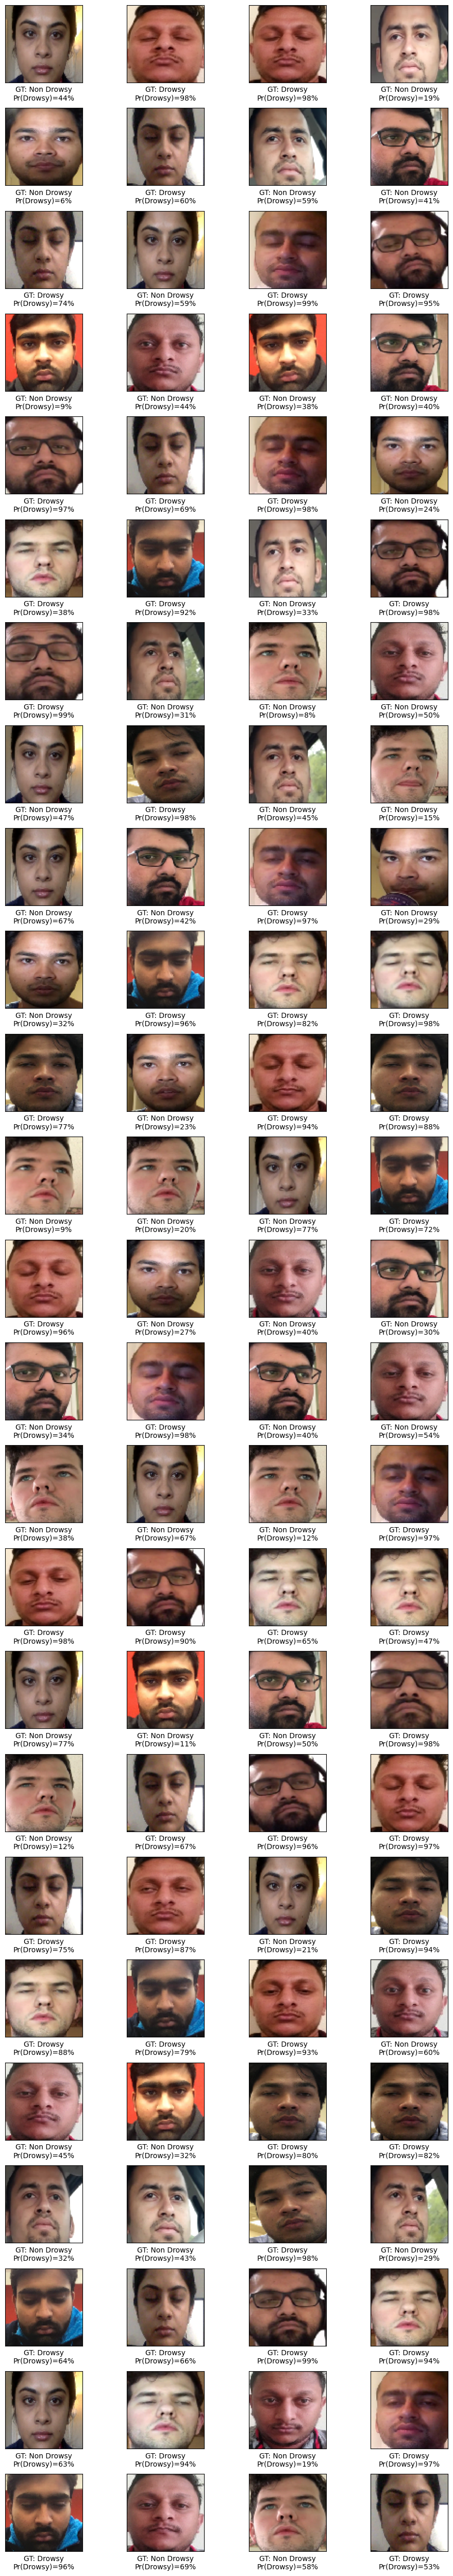

Shape of image: (1, 80, 80, 3)


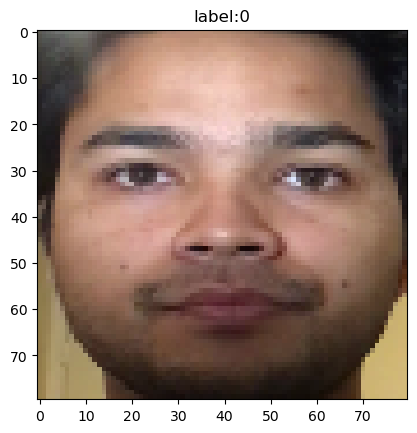

1/1 [==============================] - 0s 59ms/step


2023-12-03 20:54:27.476871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


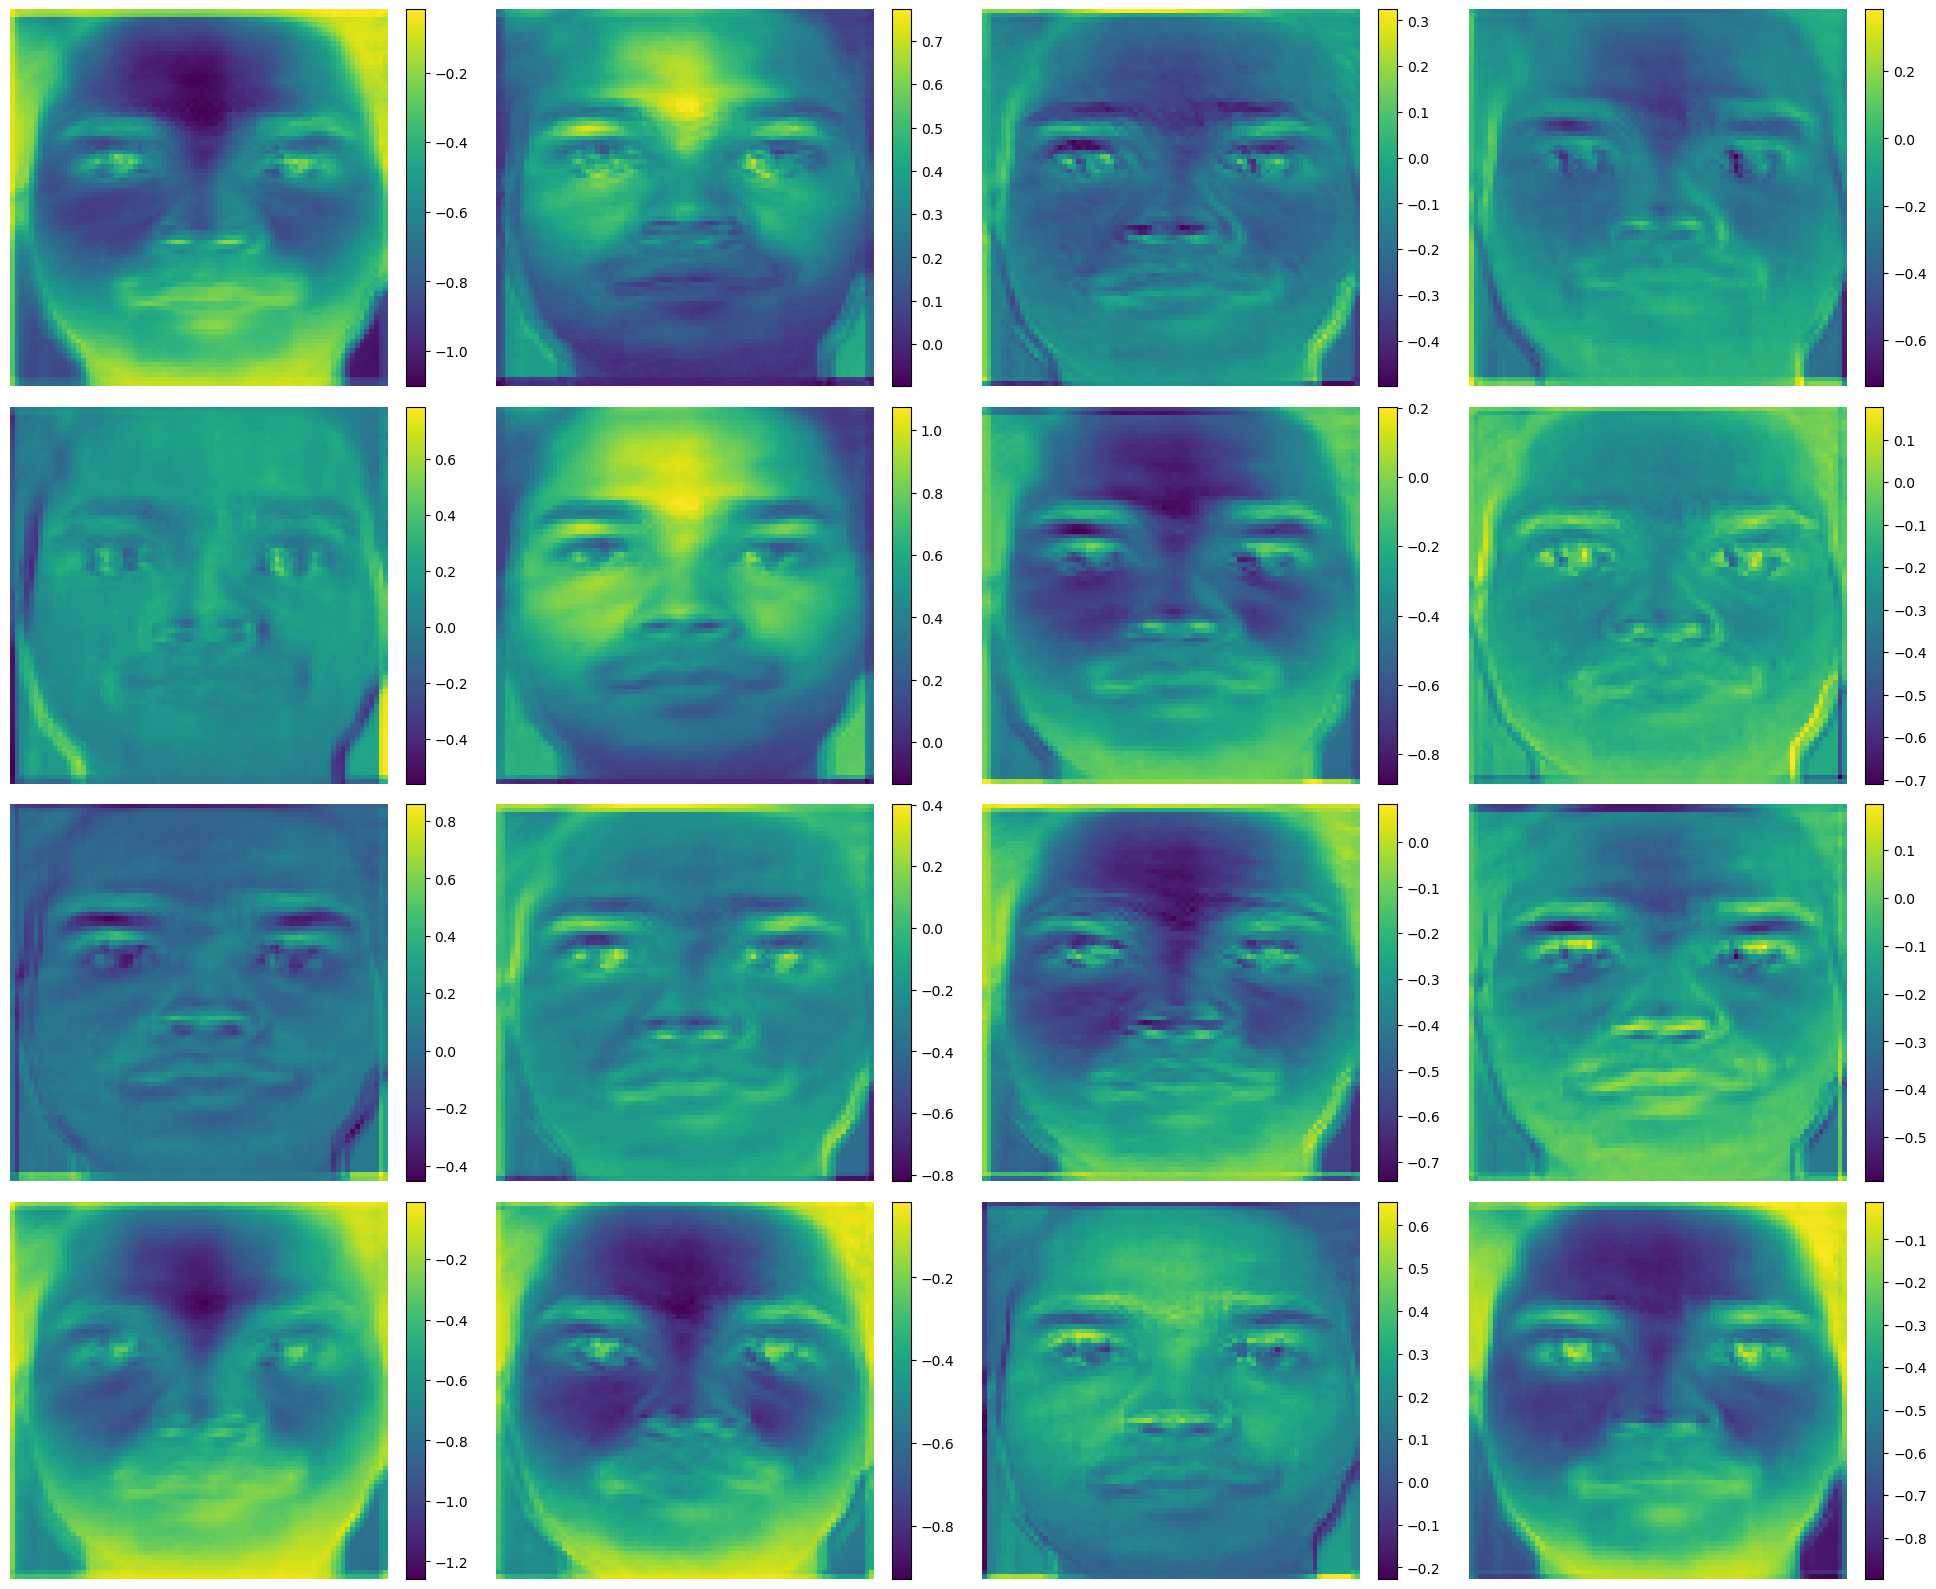

2023-12-03 20:54:28.582184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 76ms/step


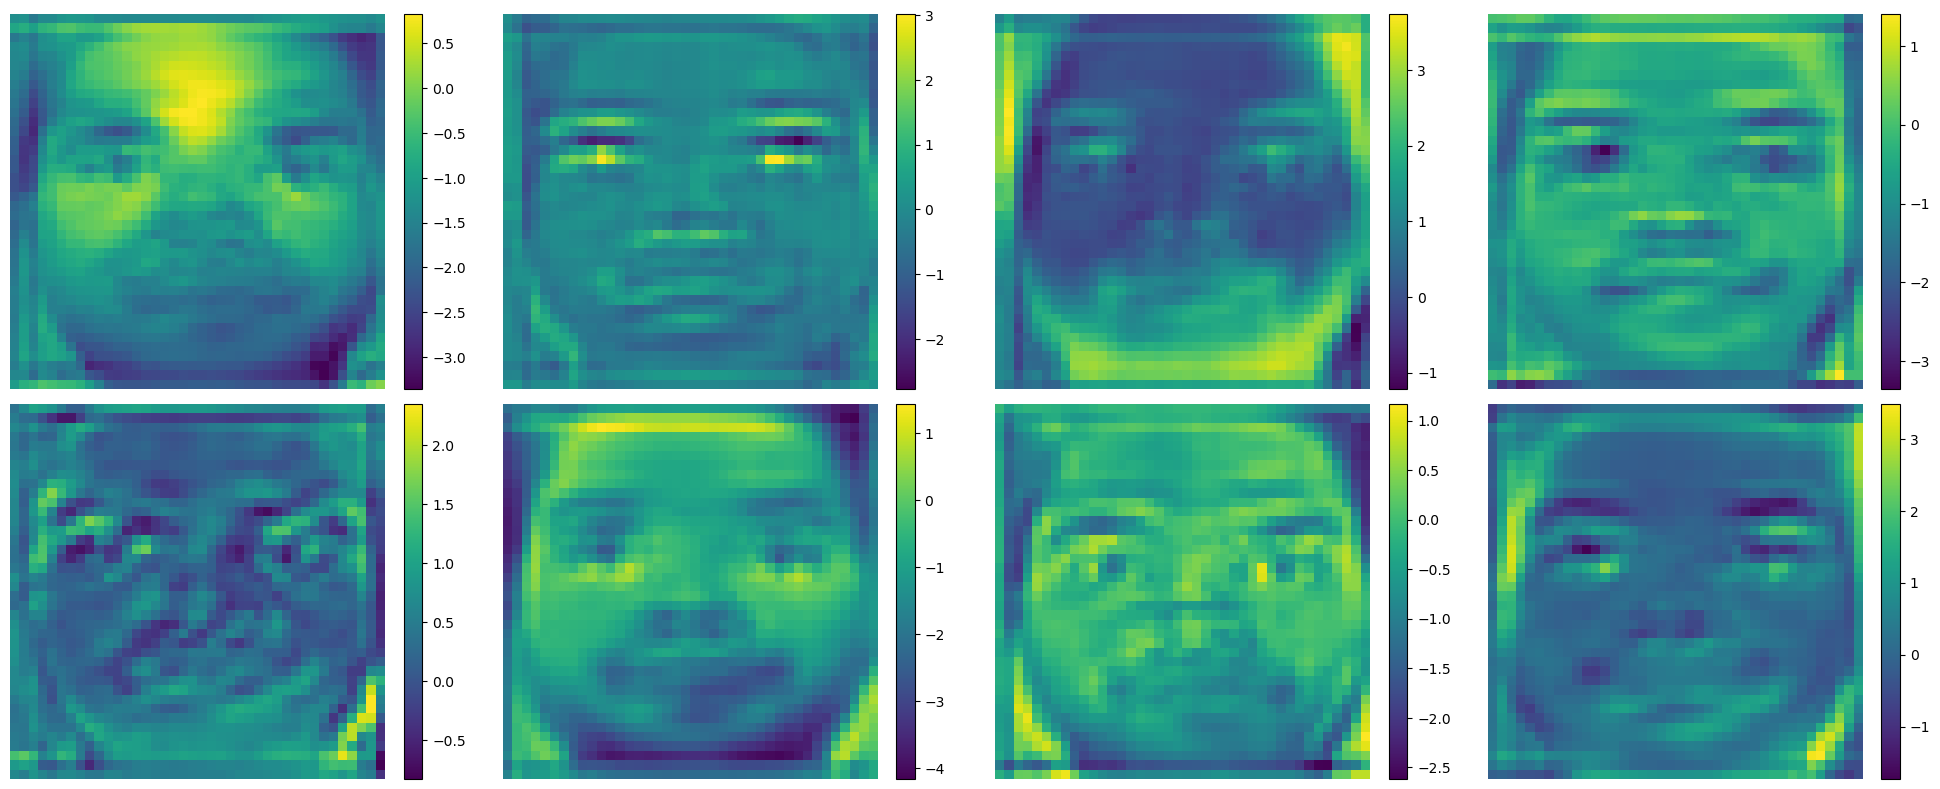

In [36]:
# Evaluate the model on the test data
image_test, label_test = predict_drowsy(model_ff, ff_test_dir, normalize=True, num_images=50)

# Select a specific image from the test set
IMG_NUM = 4
img_tensor = np.expand_dims(image_test[IMG_NUM], axis=0)

# Print the shape of the image tensor
print('Shape of image:', img_tensor.shape)

# Display the image
plt.imshow(img_tensor[0])
plt.title('label:' + str(label_test[IMG_NUM]))
plt.show()

# Plot the filter activations for the first convolutional layer
plot_filter_activations(model_ff, 'conv_1', img_tensor)

# Plot the filter activations for the second convolutional layer
plot_filter_activations(model_ff, 'conv_2', img_tensor)

`Plot Predictions/Plot Activations (Eye)`

In [ ]:
# Evaluate the model on the test data
#image_test, label_test = predict_drowsy(model_eye, eye_test_dir, normalize=True, num_images=50)
image_test, label_test = predict_drowsy(model_eye, '/Users/mayank/Downloads/face2/eye/', normalize=True, num_images=4)

# Select an image from the test set
IMG_NUM = 3

# Expand the dimensions of the image tensor to match the model's input shape
img_tensor = np.expand_dims(image_test[IMG_NUM], axis=0)

# Print the shape of the image tensor
print('Shape of image:', img_tensor.shape)

# Display the image
plt.imshow(img_tensor[0])
plt.title('label:' + str(label_test[IMG_NUM]))
plt.show()

# Plot the filter activations for the first convolutional layer
plot_filter_activations(model_eye, 'conv_1', img_tensor)

# Plot the filter activations for the second convolutional layer
plot_filter_activations(model_eye, 'conv_2', img_tensor)

#### Additional Models Experimented

In [ ]:
def build_modelV1():
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    
    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))
    
    
    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))
    
    
    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2',
        activation='relu'))
    
    
    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))
    
    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    
    return model

In [ ]:
def build_modelV2():
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    
    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1'))
    
    # Add Batch Normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add the activation layer separately
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(
        rate=0.3))
    
    
    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))
    
    
    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2'))
    
    # Add Batch Normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add the activation layer separately
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(
        rate=0.5))
    
    
    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )


    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=128,
        name='fc_1', 
        activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))
    
    model.add(tf.keras.layers.Dense(
        units=64,
        name='fc_2'
    ))
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation('relu'))
    
    model.add(tf.keras.layers.Dense(
        units=32,
        name='fc_3'
        ))
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation('relu'))
    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_4',
        activation=None))
    
    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    
    return model

In [ ]:
def build_modelV3():

    # Instantiate the model
    model = tf.keras.Sequential()

    # Adding first three convolutional layers
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu', # activation function 
                    input_shape = (80,80,3) # shape of input (image)
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))

    # Adding pooling after convolutional layers
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2))) # Dimensions of the region that you are pooling

    # Adding second set of convolutional layers
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))

    # Add last pooling layer.
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())

    # Adding first dense layer with 256 nodes
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    # Adding a dropout layer to avoid overfitting
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3)) 

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # adding output layer
    model.add(tf.keras.layers.Dense(1, activation = None))

        # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))

    return model

#### Aditional utility function to predict images in a directory

In [ ]:
from tensorflow import keras
import pandas as pd
from IPython.display import display, Image

keras.backend.clear_session()

#model_ = keras.models.load_model(model_dir + '/model_ff.h5')
model_ = model_eye
    
def predict(model, img):
    img= keras.utils.load_img(
        img, target_size=(80, 80))
    img_array = keras.utils.img_to_array(img)
    img_array = img_array/255.0
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    probas = tf.sigmoid(predictions)
    probas = probas.numpy().flatten() * 100
    print (probas)

    return predictions


dir_path = "/Users/mayank/Downloads/face2/face/Drowsy/face2.jpg"

predictions = predict(model_, dir_path)
print (predictions)



In [ ]:


'''
i = 0
file_path = []
prediction_results = []
for file_name in os.listdir(dir_path):
    
    predictions = predict(model, dir_path+file_name)
    
    print (predictions)
    
    # Convert logits to probabilities
    probabilities = tf.nn.sigmoid(predictions).numpy()
    
    prediction_results.append(probabilities[0])
    file_path.append(dir_path+file_name)



data = {'file_path': file_path, 'prediction_results': prediction_results}
df = pd.DataFrame(data)



# Display the dataframe with filepath as a link to the image
for index, row in df.iterrows():
    display(Image(filename=row['file_path']))
    print(row)


    

# Define the grid size based on the number of images
num_images = len(df)
grid_size = int(num_images ** 0.5) + 1

# Create a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Iterate over the dataframe rows and display the image with prediction result
for index, row in df.iterrows():
    img = plt.imread(row['file_path'])
    ax = axs[index // grid_size, index % grid_size]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Prediction: {row['prediction_results']:.2f}")

# Remove empty subplots
for i in range(num_images, grid_size ** 2):
    axs[i // grid_size, i % grid_size].axis('off')

plt.tight_layout()
plt.show()




print(np.array(prediction_results))
array = np.array(prediction_results)
print(np.size(array))

um_elements_greater_than_zero = np.sum(array > 0)

print (um_elements_greater_than_zero)

um_elements_less_than_zero = np.sum(array < 0)
print (um_elements_less_than_zero)
'''

In [ ]:
from itertools import product

learning_rate               =   [0.001,
                                 0.01]
 
optimizer                   =   ['adam',
                                 'adagrad', 
                                 'sgd']
                                 
                        
filters                     =   [[16,16],
                                 [16,8],
                                 [8,16], 
                                 [8,8]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)], 
                                 [(3,3),(5,5)], 
                                 [(5,5),(3,3)]]
 
strides                     =   [[(1,1),(1,1)], 
                                 [(2,2),(2,2)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [64, 64, 32]]

epochs                      =   [10, 20, 30, 40]


def build_permutations(lists):

    # Generate permutations of one element from each list
    all_permutations = list(product(*lists))

    # Print the permutations
    for idx, permutation in enumerate(all_permutations, start=1):
        print(f"Permutation {idx}: {permutation}")


    permutation = all_permutations[0]
    print(permutation[0])

lists = [learning_rate, optimizer, filters, kernel_size, strides, pool_size, conv_dropout_rate, fc_dropout_rate, conv_batch_normalization, fc_batch_normalization, activations, units, epochs]
build_permutations(lists)

In [ ]:
NUM_EXP = 5

learning_rate               =   [0.001,
                                 0.001,
                                 0.001,
                                 0.001,
                                 0.001]
 
optimizer                   =   ['adam',
                                 'adam', 
                                 'adam', 
                                 'adam',
                                 'adam']
                                 
                        
filters                     =   [[16,16],
                                 [16,16],
                                 [16,16], 
                                 [16,16],
                                 [16,16]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)], 
                                 [(3,3), (5,5)], 
                                 [(5,5), (3,3)],
                                 [(5,5),(5,5)]]
 
strides                     =   [[(1,1),(1,1)], 
                                 [(1,1),(1,1)], 
                                 [(1,1),(1,1)], 
                                 [(1,1),(1,1)],
                                 [(1,1),(1,1)]]

pool_size                   =   [[(2,2),(2,2)],
                                 [(2,2),(2,2)],
                                 [(2,2),(2,2)], 
                                 [(2,2),(2,2)],
                                 [(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5],
                                 [0.3, 0.5], 
                                 [0.3, 0.5], 
                                 [0.3, 0.5],
                                 [0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0],
                                 [0.5, 0, 0], 
                                 [0.5, 0, 0], 
                                 [0.5, 0, 0],
                                 [0.5, 0, 0]]

conv_batch_normalization    =   [[True, True],
                                 [True, True], 
                                 [True, True], 
                                 [True, True],
                                 [True, True]]

fc_batch_normalization      =   [[False, True, True],
                                 [False, True, True], 
                                 [False, True, True], 
                                 [False, True, True],
                                 [False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [128, 64, 32],
                                 [128, 64, 32],
                                 [128, 64, 32],
                                 [64, 64, 32]]

In [ ]:
from itertools import product

learning_rate               =   [0.001,
                                 0.01]
 
optimizer                   =   ['adam',
                                 'adagrad', 
                                 'sgd']
                                 
                        
filters                     =   [[16,16],
                                 [16,8],
                                 [8,16], 
                                 [8,8]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)]]
                                 
 
strides                     =   [[(1,1),(1,1)], 
                                 [(2,2),(2,2)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [64, 64, 32]]

epochs                      =   [20, 30, 40]
